In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-time-series-20050101-to-20171231/CAT_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UTX_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PFE_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PG_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UNH_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/JNJ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/VZ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/AABA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/BA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/KO_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/MCD_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/MRK_

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:

amzn = pd.read_csv('../input/stock-time-series-20050101-to-20171231/AMZN_2006-01-01_to_2018-01-01.csv',
index_col='Date', parse_dates=['Date'])
amzn.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [4]:
amzn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


In [5]:
amzn.reset_index(inplace=True)

In [6]:
# Adding more features to the dataset, in the form day of week, month, and year
amzn['month'] = pd.to_datetime(amzn['Date']).dt.month
amzn['day'] = pd.to_datetime(amzn['Date']).dt.day
amzn['day_name'] = pd.to_datetime(amzn['Date']).dt.day_name()
amzn['year'] = pd.to_datetime(amzn['Date']).dt.year
amzn.head()

,Date,Open,High,Low,Close,Volume,Name,month,day,day_name,year
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN,1,3,Tuesday,2006
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN,1,4,Wednesday,2006
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN,1,5,Thursday,2006
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN,1,6,Friday,2006
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN,1,9,Monday,2006


In [7]:
amzn.set_index('Date', inplace=True)

In [8]:
amzn.head()

,Open,High,Low,Close,Volume,Name,month,day,day_name,year
Date,,,,,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN,1,3,Tuesday,2006
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN,1,4,Wednesday,2006
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN,1,5,Thursday,2006
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN,1,6,Friday,2006
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN,1,9,Monday,2006


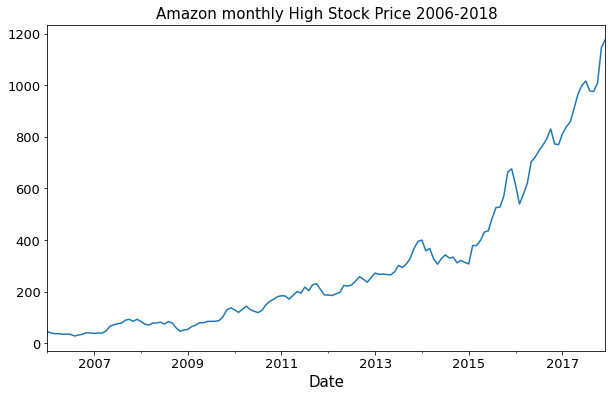

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
amzn['High'].resample('M').mean().plot(fontsize=13)
ax.set_xlabel(xlabel='Date', fontsize=15)
plt.title('Amazon monthly High Stock Price 2006-2018', fontsize=15);

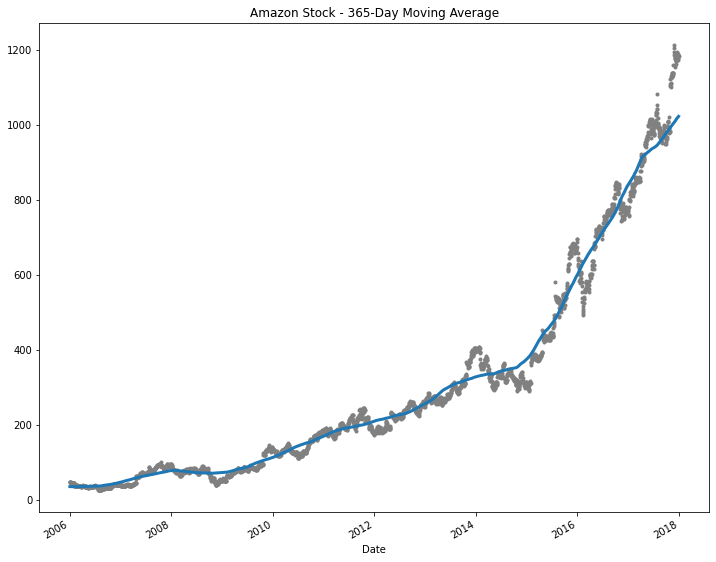

In [10]:
fig, ax = plt.subplots(figsize=(12,10))
trend = amzn['High'].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = amzn['High'].plot(style=".", color="0.5")
trend.plot(
    ax=ax, linewidth=3, title="Amazon Stock - 365-Day Moving Average", legend=False,
);

In [11]:
total_days = len(amzn.index)
val_cut = amzn.index[int(0.9 * total_days)+1]
X_train1 = amzn[amzn.index < val_cut]
X_val = amzn[amzn.index >= val_cut]

In [12]:
X_tr_tot_days = len(X_train1.index)
test_cut = X_train1.index[int(0.75 * X_tr_tot_days)+1]
X_train2 = X_train1[X_train1.index < test_cut]
X_test = X_train1[X_train1.index >= test_cut]

In [13]:
print(max(X_train2.index))
print(min(X_test.index))
print(max(X_test.index))
print(min(X_val.index))

2014-02-10 00:00:00
2014-02-11 00:00:00
2016-10-19 00:00:00
2016-10-20 00:00:00


In [14]:
X_tr = X_train2.drop('Close', axis=1)
X_te = X_test.drop('Close', axis=1)
X_val2 = X_val.drop('Close', axis=1)
y_tr2 = X_train2['Close']
y_te = X_test['Close']
y_val = X_val['Close']

In [15]:
dp = DeterministicProcess(
    index=X_tr.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=4,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed,trend**4
Date,,,,,
2006-01-03,1.0,1.0,1.0,1.0,1.0
2006-01-04,1.0,2.0,4.0,8.0,16.0
2006-01-05,1.0,3.0,9.0,27.0,81.0
2006-01-06,1.0,4.0,16.0,64.0,256.0
2006-01-09,1.0,5.0,25.0,125.0,625.0


In [16]:

model = LinearRegression(fit_intercept=False)
model.fit(X, y_tr2)

y_pred = pd.Series(model.predict(X), index=X.index)


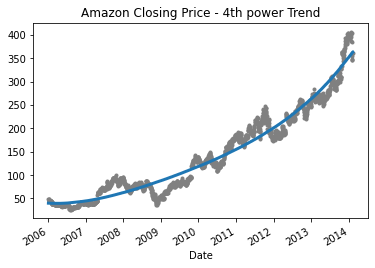

In [17]:
ax = y_tr2.plot(style=".", color="0.5", title="Amazon Closing Price - 4th power Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [18]:
print(f'X_test_length: {len(X_test)}')
print(f'X_val_length: {len(X_val)}')
print(f'X_test_val_length: {len(X_test)+len(X_val)}')

X_test_length: 679
X_val_length: 301
X_test_val_length: 980


In [19]:
X_test_val = pd.concat([X_test, X_val], axis=0)

In [20]:
X_out = dp.out_of_sample(steps=679, forecast_index=X_te.index)

y_fore = pd.Series(model.predict(X_out), index=X_out.index)

y_fore.head()

Date
2014-02-11    363.487115
2014-02-12    363.927137
2014-02-13    364.367808
2014-02-14    364.809129
2014-02-18    365.251100
dtype: float64

In [21]:
X_out_val = dp.out_of_sample(steps=980, forecast_index=X_test_val.index)

y_fore_val = pd.Series(model.predict(X_out_val), index=X_out_val.index)

y_fore_val.head()

Date
2014-02-11    363.487115
2014-02-12    363.927137
2014-02-13    364.367808
2014-02-14    364.809129
2014-02-18    365.251100
dtype: float64

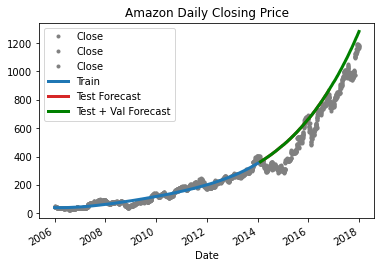

In [22]:
ax = y_tr2.plot(style=".", color="0.5", title="Amazon Daily Closing Price")
ax = y_te.plot(style=".", color="0.5",)
ax = y_val.plot(style=".", color="0.5")
ax = y_pred.plot(ax=ax, linewidth=3, label="Train")
ax = y_fore.plot(ax=ax, linewidth=3, label="Test Forecast", color="C3")
ax = y_fore_val.plot(ax=ax, linewidth=3, label="Test + Val Forecast", color="green")
_ = ax.legend()